In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

# Functions to plot the data

In [225]:
def plotdata(filename='./sim_perf.txt', ttl=''):
    sd = pd.read_csv(filename, sep=';')
    sd['loss'] = sd['loss'].astype(float)
    sd['epsilon'] = sd['epsilon'].astype(float)
    sd['percentselect'] = sd['nselect'] / (sd['nselect'] + sd['nskip'])
    plt.figure(figsize=(16, 8))
    plt.title(ttl)
    plt.plot(sd['epoch'], sd['oracleF1'], c='red', label='Oracle F1')
    plt.plot(sd['epoch'], sd['randomF1'], c='black', label='Random F1')
    plt.plot(sd['epoch'], sd['rougeF1'], c='blue', label='F1')
    plt.plot(sd['epoch'], sd['rougePrecision'], c='green', label='Precision')
    plt.plot(sd['epoch'], sd['rougeRecall'], c='purple', label='Recall')
    plt.plot(sd['epoch'], sd['percentselect'], c='orange', label='Select Rate')
    plt.ylim([0,1])
    plt.ylabel("Rouge Value")
    plt.xlabel("Training Epoch")
    plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.15))
    plt.grid()
    plt.show()
    plt.figure(figsize=(16, 4))
    plt.plot(sd['epoch'], sd['loss'], c='red', label='Loss')
    plt.legend()
    plt.ylabel("Loss Value")
    plt.grid()
    plt.show()
    
def plotCompare(bowfile, lstmfile, ttl=''):
    bdf = pd.read_csv(bowfile, sep=';')
    ldf = pd.read_csv(lstmfile, sep=';')
    bdf['percentselect'] = bdf['nselect'] / (bdf['nselect'] + bdf['nskip'])
    ldf['percentselect'] = ldf['nselect'] / (ldf['nselect'] + ldf['nskip'])

    fig = plt.figure(figsize=(16, 4))
    plt.title(ttl)
    plt.plot(bdf['epoch'], bdf['oracleF1'], c='red', label='Oracle - F1')
    plt.plot(bdf['epoch'], bdf['randomF1'], c='black', label='Random - F1')
    plt.plot(bdf['epoch'], bdf['rougeF1'], c='blue', label='BOW - F1')
    plt.plot(ldf['epoch'], ldf['rougeF1'], c='purple', label='LSTM - F1')
    plt.ylabel("Rouge F1")
    plt.xlabel("Training Epoch")
    plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.30))
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(16, 4))
    plt.plot(bdf['epoch'], bdf['percentselect'], c='orange', label='BOW - Select Rate')
    plt.plot(ldf['epoch'], ldf['percentselect'], c='green', label='LSTM - Select Rate')
    plt.title("Selection Rate by Model")
    plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.30))
    plt.ylabel("Selection Rate")
    plt.xlabel("Training Epoch")
    plt.grid()
    plt.show()
    
def buildSelection(model, nepochs):
    ofile_names = [('./plotdata/%s/%i_epoch.txt' % (model, x) ) for x in range(nepochs) ] 
    for (ofile, epoch) in zip(ofile_names, range(nepochs)):
        odf = pd.read_csv(ofile, sep=';')
        if epoch==0:
            tdf = pd.DataFrame(pd.Series(odf['Skip']))
            tdf['Select'] = odf['Select']
        else:
            tdf['Skip'] += odf['Skip']
            tdf['Select'] += odf['Select']
            
    tdf['SkipRate'] = tdf['Skip'] / float(nepochs)
    tdf['SelectRate'] = tdf['Select'] / float(nepochs)
    tdf = tdf.reset_index()
    return tdf
    
def plotSelection(bowmodel, lstmmodel, nepochs):
    bowdf = buildSelection(bowmodel, nepochs)
    lstmdf = buildSelection(lstmmodel, nepochs)
    f, axarr = plt.subplots(1, 2, figsize=(16,8))
    axarr[0].barh(bowdf['index'], bowdf['SelectRate'], color='red', edgecolor='white')
    axarr[0].set_ylim(axarr[0].get_ylim()[::-1])
    axarr[1].barh(lstmdf['index'], lstmdf['SelectRate'], color='blue', edgecolor='white')
    axarr[1].set_ylim(axarr[1].get_ylim()[::-1])
    axarr[0].set_xlabel("Selection Percentage")
    axarr[1].set_xlabel("Selection Percentage")
    axarr[0].set_title('BOW')
    axarr[1].set_title('LSTM')
    f.suptitle("Sentence Selection Percentage across Epochs", fontsize=20, y=1.05)
    f.tight_layout()
    f.show()

---
# LSTM Model
---

## Learning Precision on 20 Records

In [14]:
! time th runModel.lua --nepochs 4 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 10 --metric precision --n_samples 10 \
    --base_explore_rate 0.05 --model bow --end_baserate 100 --usecuda


...Utils file loaded	
...running on GPU	
Running bag-of-words model to learn precision	
Back prop	
/Users/franciscojavierarceo/torch/install/bin/luajit: ...ierarceo/torch/install/share/lua/5.1/nn/MaskedSelect.lua:18: bad argument #1 to 'maskedSelect' (torch.DoubleTensor expected, got torch.CudaTensor)
stack traceback:
	[C]: in function 'maskedSelect'
	...ierarceo/torch/install/share/lua/5.1/nn/MaskedSelect.lua:18: in function 'forward'
	utilsNN.lua:281: in function 'opfunc'
	...avierarceo/torch/install/share/lua/5.1/optim/rmsprop.lua:35: in function 'rmsprop'
	utilsNN.lua:289: in function 'backPropOld'
	utilsNN.lua:504: in function 'train'
	runModel.lua:99: in main chunk
	[C]: in function 'dofile'
	...rceo/torch/install/lib/luarocks/rocks/trepl/scm-1/bin/th:145: in main chunk
	[C]: at 0x0101e08b90

real	0m3.401s
user	0m2.327s
sys	0m0.913s


...Utils file loaded	
...running on CPU	
Running LSTM model to learn precision	
Model complete {Selected = 1; Skipped  = 18}; Final Rouge Recall, Precision, F1 = {0.008222;0.640000;0.016235}	

real	20m2.910s
user	20m6.945s
sys	0m33.849s


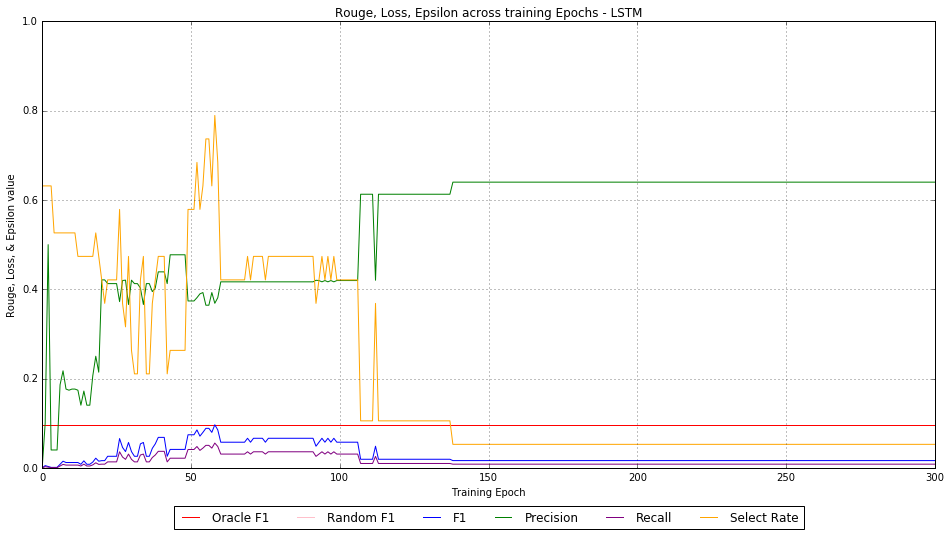

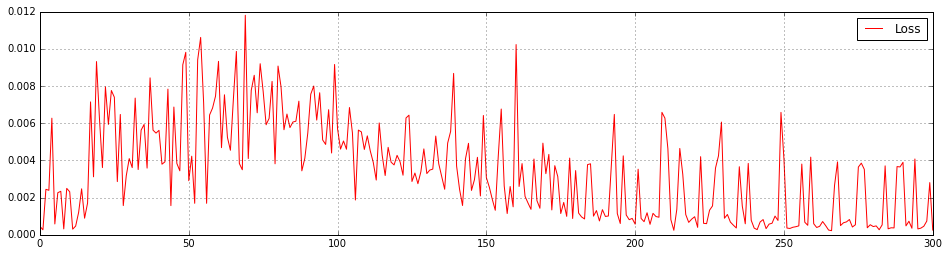

In [3]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric precision --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 100

_ = plotdata('./Performance/lstm_precision_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning Recall on 20 Records

...Utils file loaded	
...running on CPU	
Running LSTM model to learn recall	
Model complete {Selected = 17; Skipped  = 2}; Final Rouge Recall, Precision, F1 = {0.050874;0.330000;0.088157}	

real	7m0.995s
user	6m56.112s
sys	0m15.776s


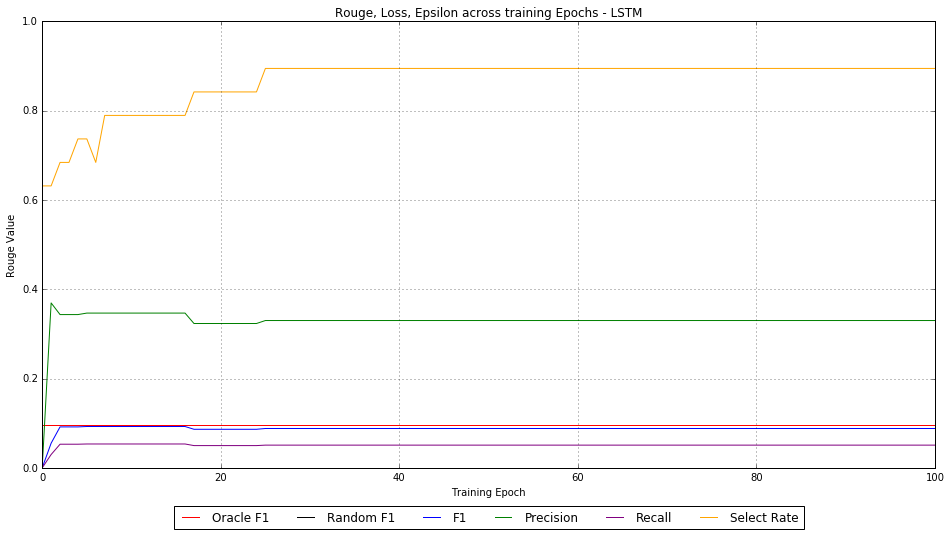

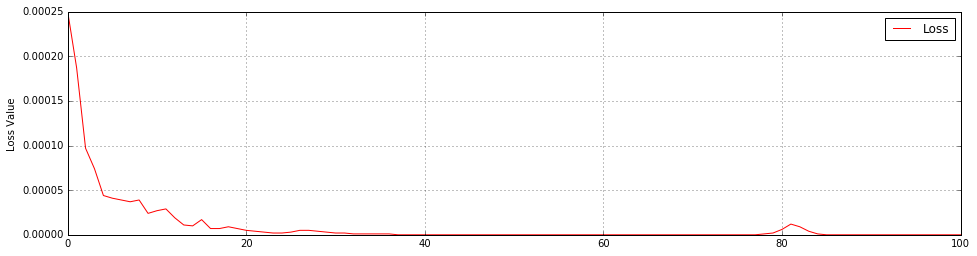

In [213]:
! time th runModel.lua --nepochs 100 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.0 --model lstm --end_baserate 1

plotdata('./Performance/Simulation/lstm_recall_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning F1 on 20 Records

...Utils file loaded	
...running on CPU	
Running LSTM model to learn f1	
Model complete {Selected = 15; Skipped  = 4}; Final Rouge Recall, Precision, F1 = {0.053957;0.350000;0.093500}	

real	6m53.500s
user	6m49.940s
sys	0m14.259s


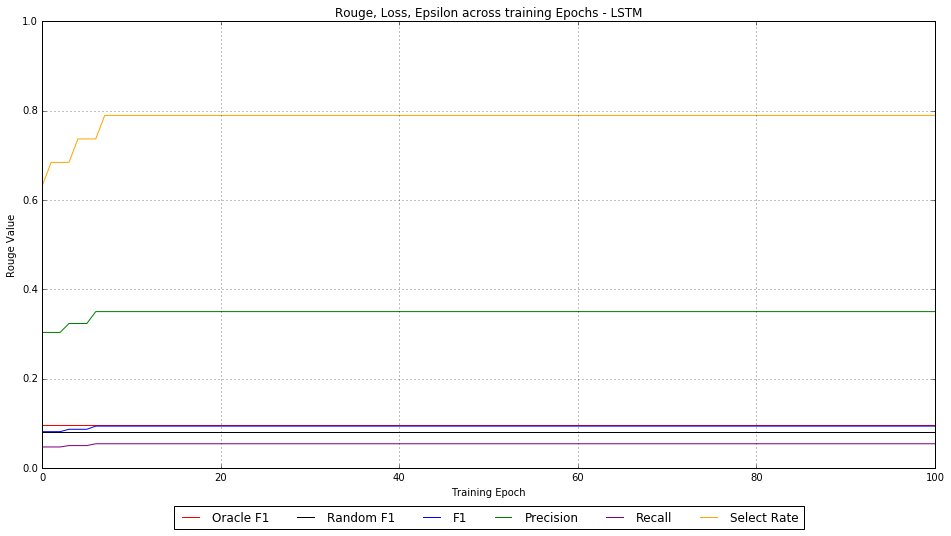

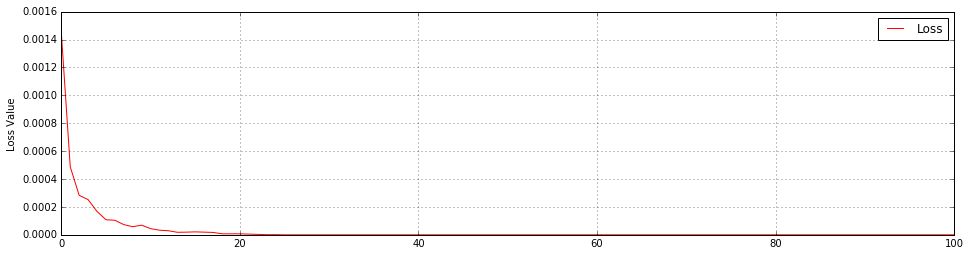

In [221]:
! time th runModel.lua --nepochs 100 --gamma 0 \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 10

plotdata('./Performance/Simulation/lstm_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

...Utils file loaded	
...running on CPU	
Running LSTM model to learn f1	
Model complete {Selected = 9; Skipped  = 10}; Final Rouge Recall, Precision, F1 = {0.041110;0.380952;0.074212}	

real	64m1.701s
user	64m21.900s
sys	1m35.500s


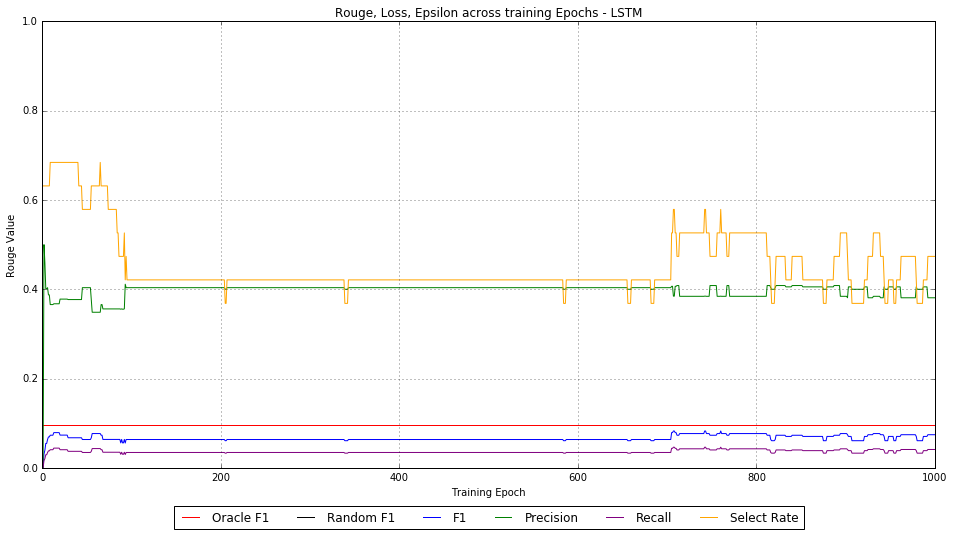

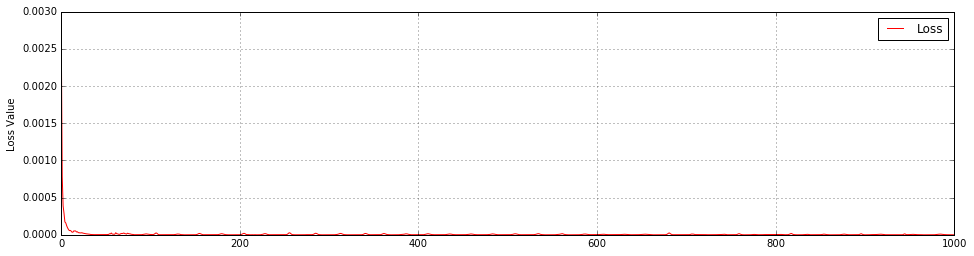

In [222]:
! time th runModel.lua --nepochs 1000 --gamma 0 \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 100

plotdata('./Performance/Simulation/lstm_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

---------
# BOW model
---------

## Learning Precision on 20 Records

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn precision	
Model complete {Selected = 17; Skipped  = 2}; Final Rouge Recall, Precision, F1 = {0.049846;0.323333;0.086376}	

real	1m25.499s
user	1m22.763s
sys	0m1.825s


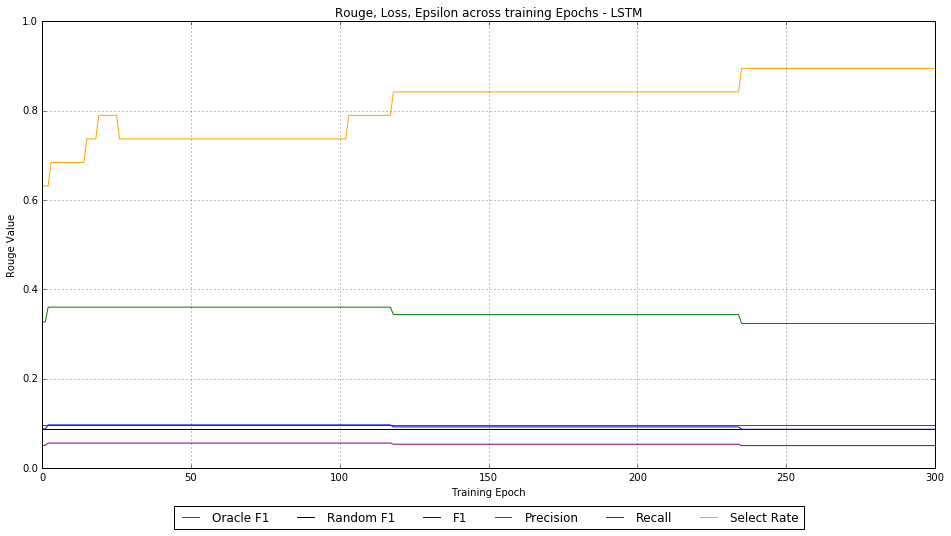

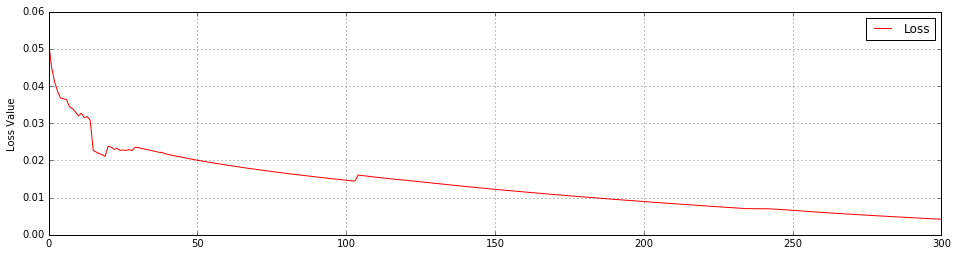

In [203]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric precision --n_samples 20 \
    --base_explore_rate 0.10 --model bow --end_baserate 100

plotdata('./Performance/Simulation/bow_precision_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning Recall on 20 Records

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn recall	
Model complete {Selected = 16; Skipped  = 3}; Final Rouge Recall, Precision, F1 = {0.050874;0.330000;0.088157}	

real	1m18.525s
user	1m17.110s
sys	0m1.237s


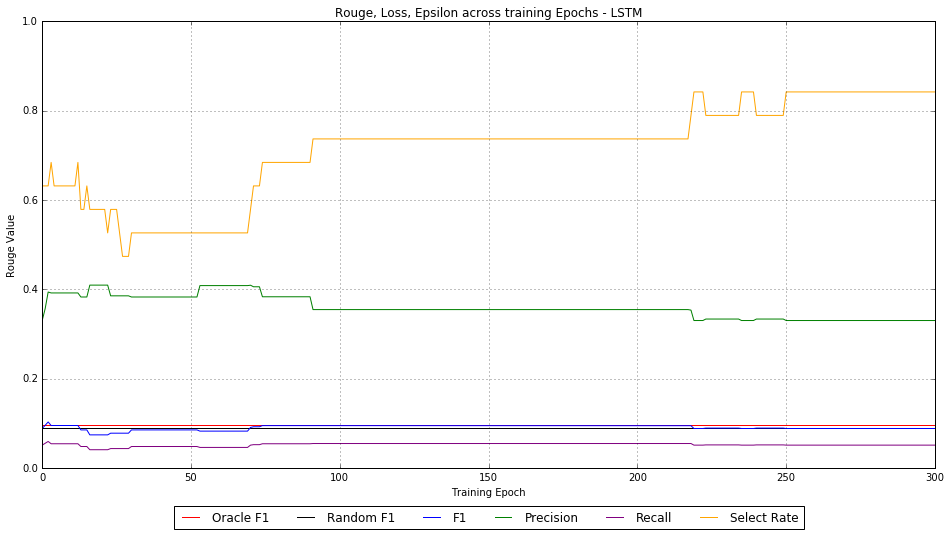

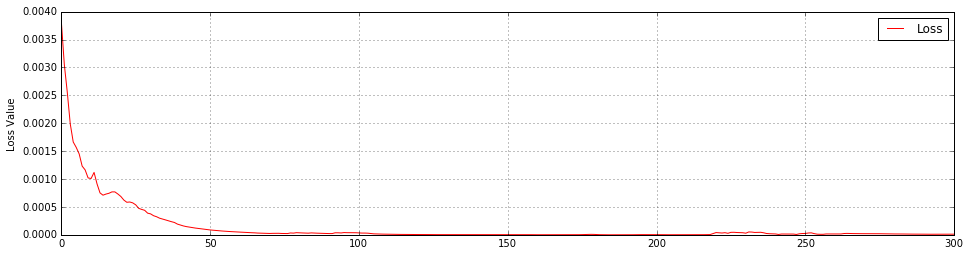

In [199]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.10 --model bow --end_baserate 100

plotdata('./Performance/Simulation/bow_recall_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning F1 on 20 Records

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn f1	
Model complete {Selected = 8; Skipped  = 11}; Final Rouge Recall, Precision, F1 = {0.024666;0.274286;0.045262}	

real	4m5.312s
user	4m3.025s
sys	0m1.752s


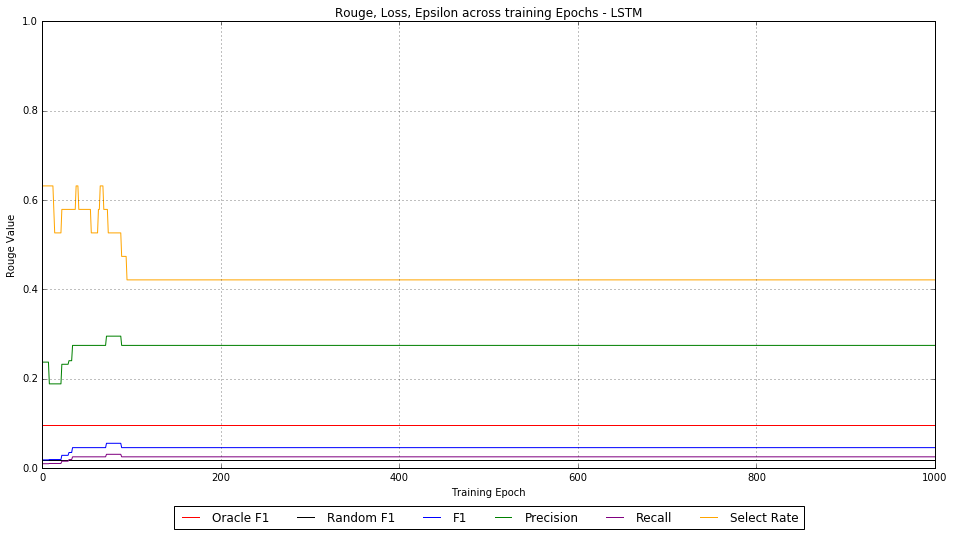

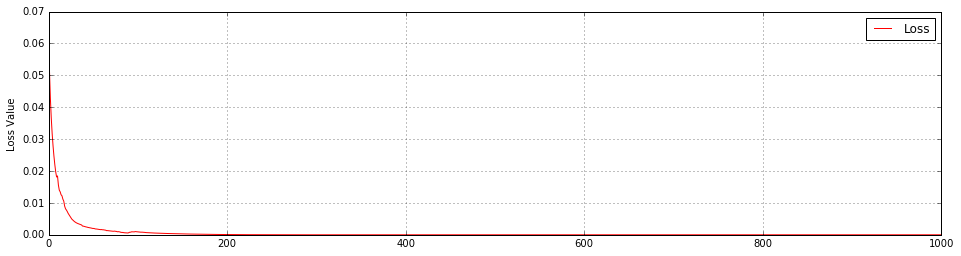

In [223]:
! time th runModel.lua --nepochs 1000 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 100

_ = plotdata('./Performance/Simulation/bow_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

# Comparison of the models

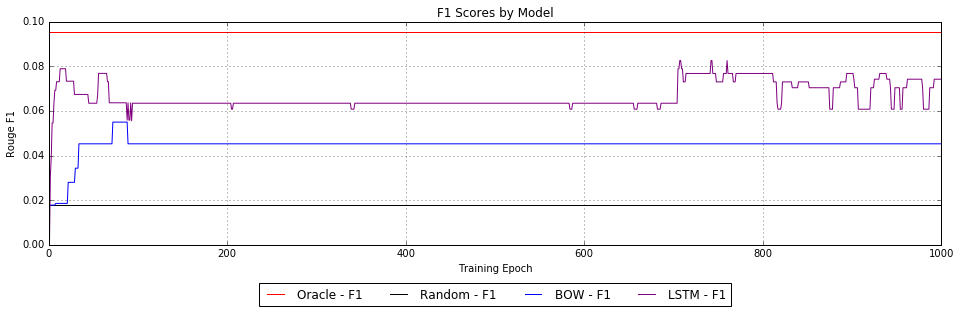

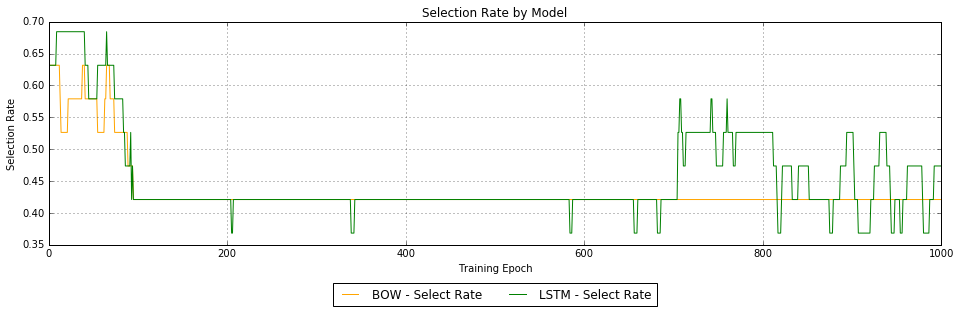

In [227]:
plotCompare('./Performance/Simulation/bow_f1_perf.txt', './Performance/Simulation/lstm_f1_perf.txt', 'F1 Scores by Model')

/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


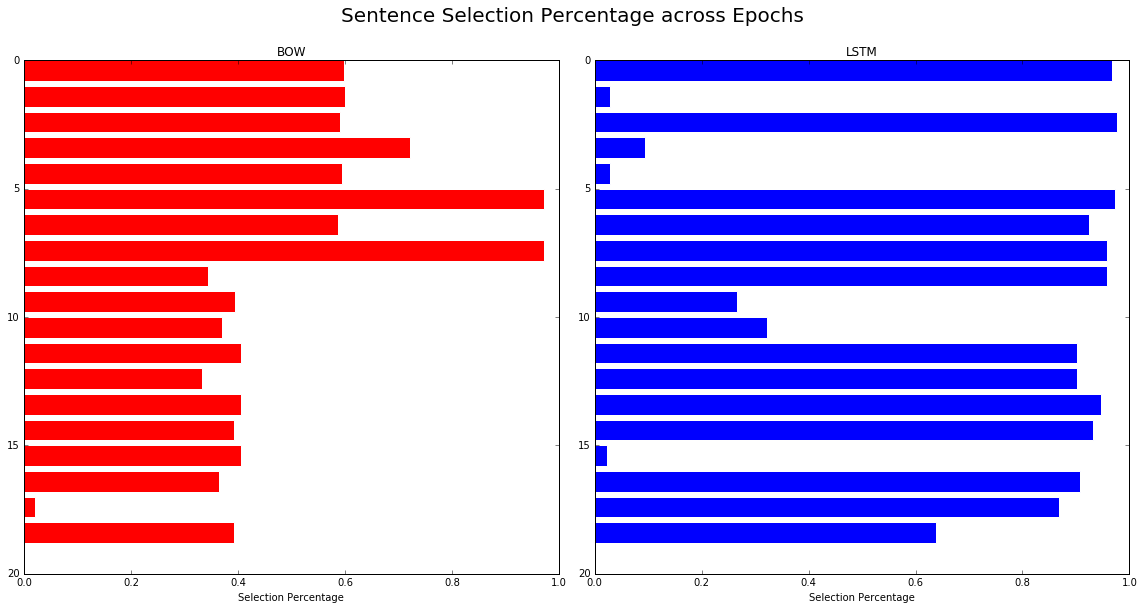

In [57]:
plotSelection('bow', 'lstm', 500)

# Running models on 100 sentences

...Utils file loaded	
...running on CPU	
Running LSTM model to learn f1	
Model complete {Selected = 30; Skipped  = 69}; Final Rouge Recall, Precision, F1 = {0.075026;0.486667;0.130009}	

real	212m4.755s
user	212m18.770s
sys	3m38.323s


AttributeError: 'Series' object has no attribute 'find'

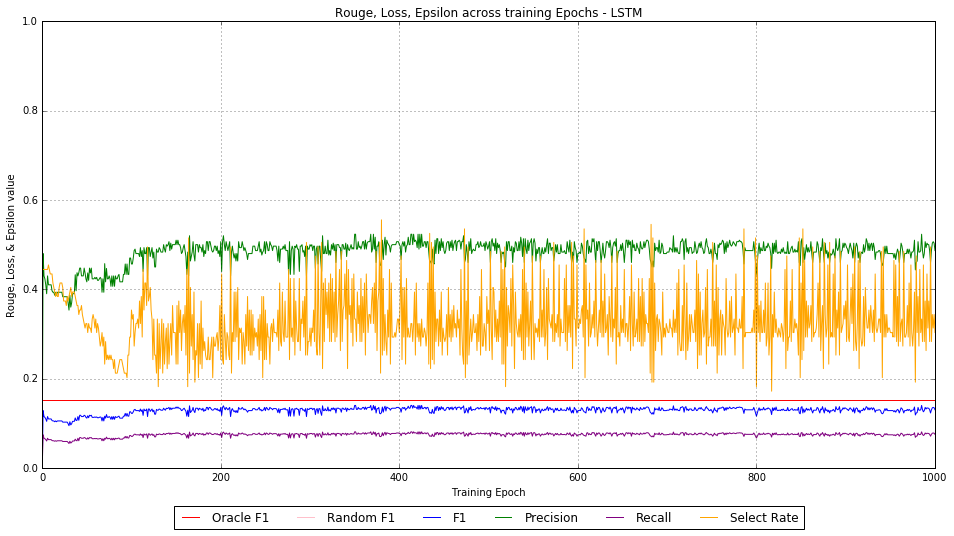

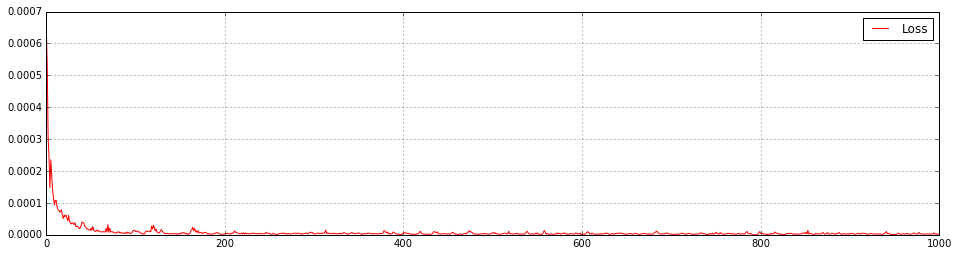

In [158]:
! time th runModel.lua --nepochs 1000 --gamma 0.0 \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 500 --metric f1 --n_samples 100 \
    --base_explore_rate 0.05 --model lstm --end_baserate 300

_ = plotdata('./Performance/Simulation/lstm_f1_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn f1	
Model complete {Selected = 19; Skipped  = 0}; Final Rouge Recall, Precision, F1 = {0.046763;0.303333;0.081033}	

real	0m5.042s
user	0m3.615s
sys	0m1.197s


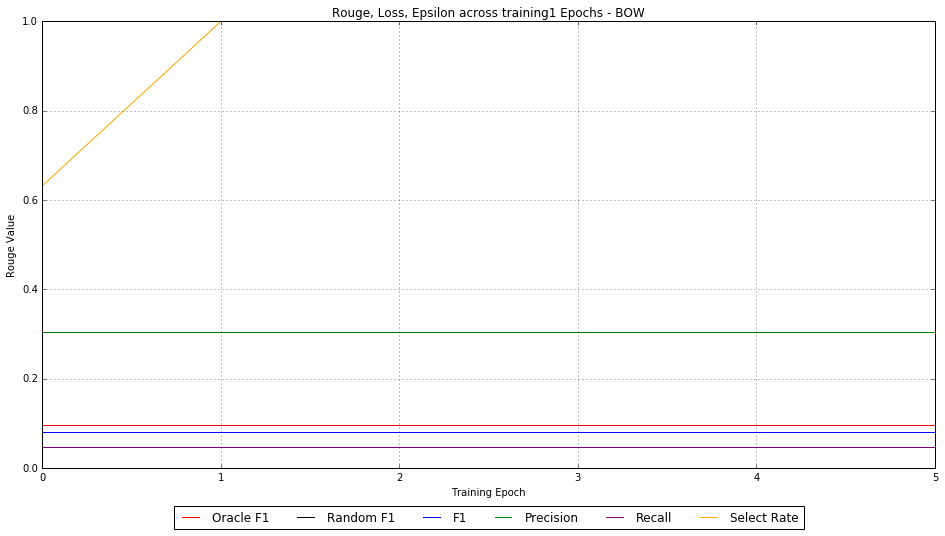

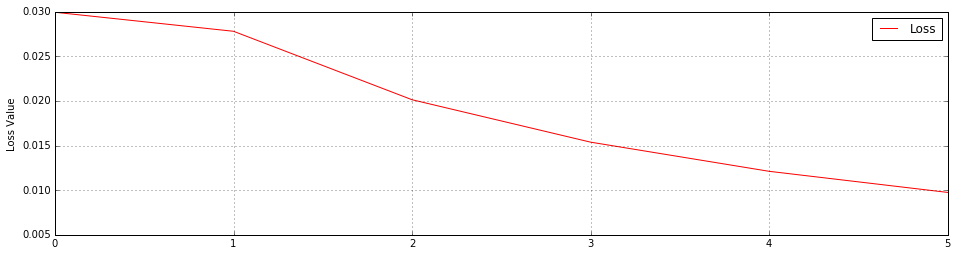

In [191]:
! time th runModel.lua --nepochs 5 --gamma 0.0 \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 400 --metric f1 --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 300

plotdata('./Performance/Simulation/bow_f1_perf.txt', 'Rouge, Loss, Epsilon across training1 Epochs - BOW')

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn f1	
Model complete {Selected = 34; Skipped  = 209}; Final Rouge Recall, Precision, F1 = {0.077081;0.500000;0.133571}	

real	19m28.664s
user	19m22.580s
sys	0m5.161s


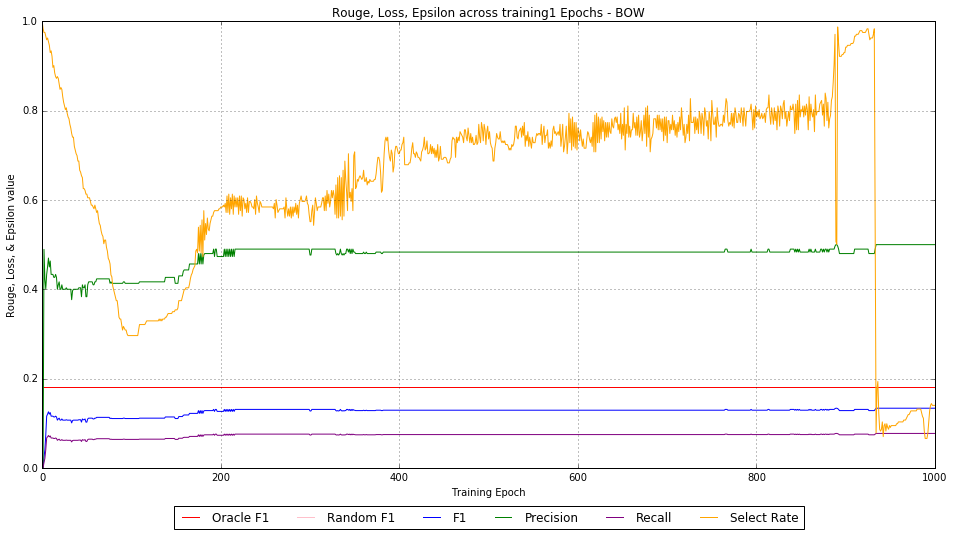

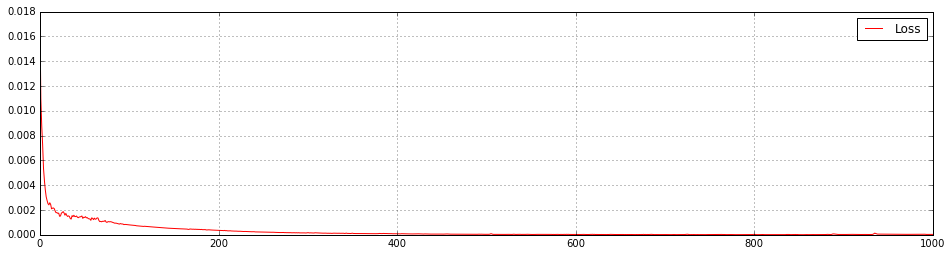

In [177]:
! time th runModel.lua --nepochs 1000 --gamma 0.0 \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 400 --metric f1 --n_samples 500 \
    --base_explore_rate 0.05 --model bow --end_baserate 300

_ = plotdata('./Performance/Simulation/bow_f1_perf.txt', 'Rouge, Loss, Epsilon across training1 Epochs - BOW')

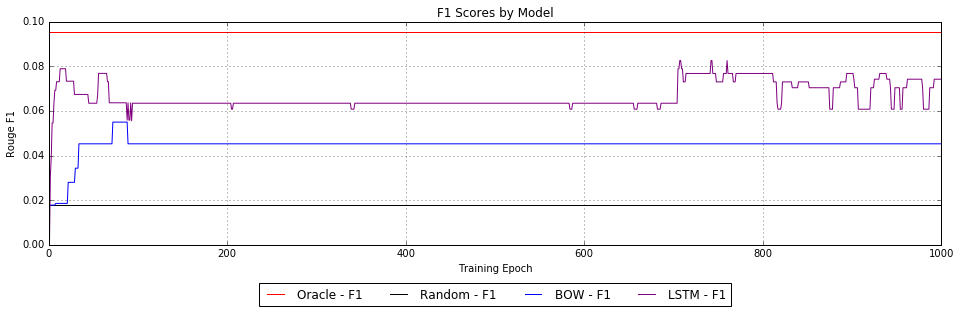

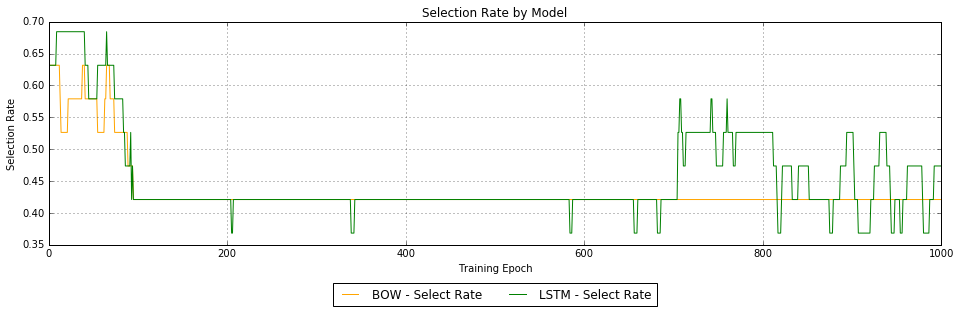

In [226]:
plotCompare('./Performance/Simulation/bow_f1_perf.txt', './Performance/Simulation/lstm_f1_perf.txt', 'F1 Scores by Model')

# Testing model on mutiple queries

In [137]:
! time th runModel.lua --nepochs 300 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --embeddingSize 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.10 --model bow --end_baserate 100

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn f1	
Model complete {Selected = 15; Skipped  = 4}; Final Rouge Recall, Precision, F1 = {0.026316;0.501901;0.050009}	

real	9m5.538s
user	9m0.759s
sys	0m3.137s


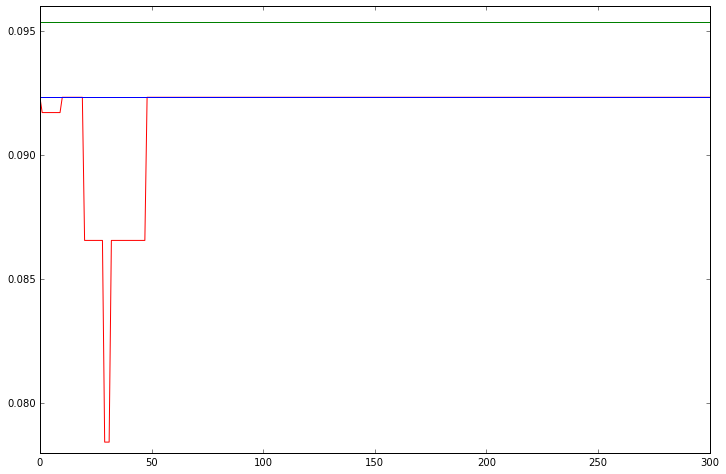

In [145]:
sd = pd.read_csv('./Performance/CV/bow_f1_perf.txt', sep=';')
tmp = sd.ix[(sd['testQuery']==1), ['epoch','rougeF1', 'randomF1','oracleF1','query']]

plt.figure(figsize = (12, 8))
plt.plot(tmp['epoch'][tmp['query']==1], tmp['rougeF1'][tmp['query']==1], c='red')
plt.plot(tmp['epoch'][tmp['query']==1], tmp['randomF1'][tmp['query']==1], c='blue')
plt.plot(tmp['epoch'][tmp['query']==1], tmp['oracleF1'][tmp['query']==1], c='green')
plt.show()

# plt.plot(tmp['epoch'][tmp['query']==2], tmp['rougeF1'][tmp['query']==2], c='blue')
# plt.plot(tmp['epoch'][tmp['query']==3], tmp['rougeF1'][tmp['query']==3], c='purple')